In [1]:
%autoreload 2

In [90]:
from collections import defaultdict
import difflib
import gzip
import os
import pickle
import sys
import time
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pactools.grid_search import GridSearchCVProgressBar
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.ast_utils import load_games_from_file, _extract_game_id

In [3]:
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')

In [4]:
game_texts = list(load_games_from_file('../dsl/interactive-beta.pddl'))

In [26]:
def embed_text(text: str, model: str = 'text-embedding-ada-002'):
    text = text.replace("\n", " ")
    return openai.Embedding.create(input = [text], model=model)


def embed_multiple_texts(texts: typing.List[str], model: str = 'text-embedding-ada-002'):
    texts = [t.replace("\n", " ") for t in texts]
    return openai.Embedding.create(input = texts, model=model)


In [39]:
REGENERATE_EMBEDDINGS = False 

if REGENERATE_EMBEDDINGS:
    result = embed_multiple_texts(game_texts)
    # embeddings = np.array([result.data[i].embedding for i in range(len(result.data))])
    embeddings = torch.tensor([result.data[i].embedding for i in range(len(result.data))])
    torch.save(embeddings, '../data/interactive-beta-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    embeddings = torch.load('../data/interactive-beta-embeddings.pt')

In [47]:
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
REGROWN_GAMES_PER_ORIGINAL = int(len(regrown_game_texts) / len(game_texts))
embeddings_by_original_game = []


In [51]:
REGENERATE_REGROWTH_EMBEDDINGS = False

if REGENERATE_REGROWTH_EMBEDDINGS:
    start_index = len(embeddings_by_original_game)

    for i in tqdm.tnrange(len(game_texts)):
        game_regrown_games = regrown_game_texts[i * REGROWN_GAMES_PER_ORIGINAL: (i + 1) * REGROWN_GAMES_PER_ORIGINAL]
        game_results = embed_multiple_texts(game_regrown_games)
        game_embeddings = torch.tensor([game_results.data[i].embedding for i in range(len(game_results.data))])
        embeddings_by_original_game.append(game_embeddings)
        time.sleep(5)

    regrown_embeddings = torch.stack(embeddings_by_original_game)
    print(regrown_embeddings.shape)
    torch.save(regrown_embeddings, '../data/ast-real-regrowth-samples-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    regrowth_embeddings = torch.load('../data/ast-real-regrowth-samples-embeddings.pt')

## Let's see what the space of these embeddings looks like

In [55]:
all_embeddings = torch.cat([embeddings, regrowth_embeddings.reshape(-1, regrowth_embeddings.shape[-1])], dim=0)
all_embeddings.shape

torch.Size([6370, 1536])

In [59]:
pca = PCA(n_components=100)
pca.fit(all_embeddings.numpy())

PCA(n_components=100)

0.036825716

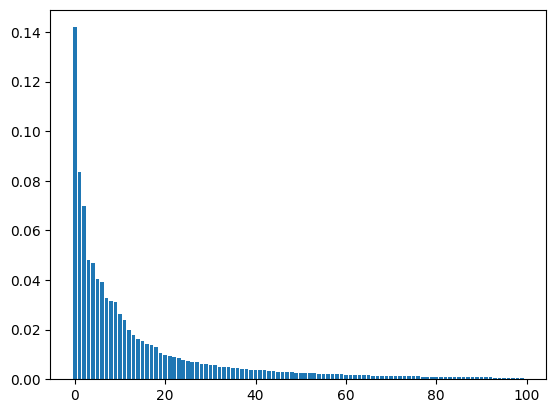

In [68]:
n_components = 100
plt.bar(np.arange(n_components), pca.explained_variance_ratio_[:n_components])
pca.explained_variance_ratio_[64:].sum()

In [69]:
PCA_N_DIM = 64
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwrags.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne

In [71]:
tsne_embedded_data = pca_and_tsne(all_embeddings.numpy())
tsne_embedded_data.shape

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(6370, 2)

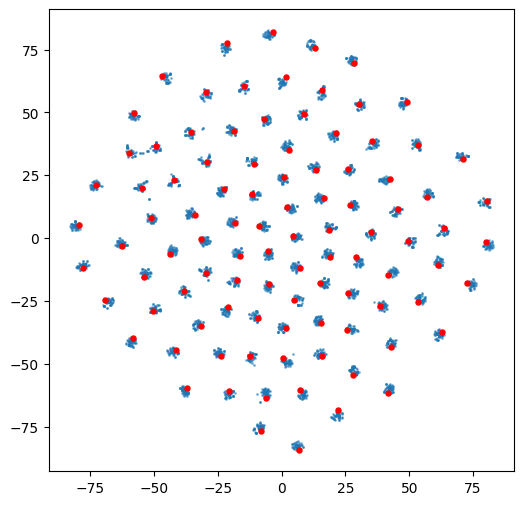

In [80]:
n_games = len(game_texts)
plt.figure(figsize=(6, 6))
plt.scatter(tsne_embedded_data[n_games:, 0], tsne_embedded_data[n_games:, 1], s=1, alpha=0.5)
plt.scatter(tsne_embedded_data[:n_games, 0], tsne_embedded_data[:n_games, 1], s=13, c='red')


## Let's see what happens if we try to fit a fitness model based on these embeddings?

In [83]:
def cross_validate(embeddings_tensor: torch.Tensor,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]],
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None, 
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    if cv_kwargs is None:
        cv_kwargs = {}

    if 'n_jobs' not in cv_kwargs: 
        cv_kwargs['n_jobs'] = -1
    if 'verbose' not in cv_kwargs:
        cv_kwargs['verbose'] = verbose

    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(model_kwargs=model_kwargs, train_kwargs=train_kwargs))])

    if isinstance(param_grid, list):
        for param_grid_dict in param_grid:
            param_grid_dict['fitness__n_features'] = [embeddings_tensor.shape[-1]]
    else:
        param_grid['fitness__n_features'] = [embeddings_tensor.shape[-1]]        

    random_seed = train_kwargs['random_seed'] if 'random_seed' in train_kwargs else None

    cv = GridSearchCVProgressBar(pipeline, param_grid, scoring=scoring_function, 
        cv=KFold(n_folds, shuffle=True, random_state=random_seed), 
        **cv_kwargs)
    return cv.fit(embeddings_tensor, None)


def model_fitting_experiment(embeddings_tensor: torch.Tensor,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]], 
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0
    ):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    cv = cross_validate(embeddings_tensor, param_grid,
        scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, 
        model_kwargs=model_kwargs, cv_kwargs=cv_kwargs, n_folds=n_folds, verbose=verbose)
    # best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore

    # TODO: add evaluation on the held-out part of the dataset here
    return cv



In [88]:
embeddings_for_fitness = torch.cat([embeddings.unsqueeze(1), regrowth_embeddings], dim=1)
embeddings_for_fitness.shape

torch.Size([98, 65, 1536])

In [96]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv = model_fitting_experiment(embeddings_for_fitness, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [97]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
670,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.03,8,1536,1.00,-0.023171,0.009461,1,1.00000,0.000000,1
346,4,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.03,4,1536,1.00,-0.024840,0.011443,2,1.00000,0.000000,1
366,4,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.01,8,1536,1.00,-0.025588,0.008913,3,1.00000,0.000000,1
46,2,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.01,8,1536,1.00,-0.025630,0.012883,4,1.00000,0.000000,1
987,16,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.03,4,1536,2.00,-0.025947,0.013846,5,1.00000,0.000000,1
458,4,16,<function fitness_hinge_loss at 0x192dd9fc0>,0.10,4,1536,1.00,-0.026207,0.005214,6,0.99935,0.000958,877
990,16,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.03,8,1536,1.00,-0.026636,0.009649,7,1.00000,0.000000,1
653,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.10,8,1536,0.25,-0.026676,0.016422,8,1.00000,0.000000,1
350,4,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.03,8,1536,1.00,-0.026706,0.014943,9,1.00000,0.000000,1
1038,16,8,<function fitness_hinge_loss at 0x192dd9fc0>,0.10,8,1536,1.00,-0.027275,0.008138,10,1.00000,0.000000,1


In [98]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
639,4,64,<function fitness_hinge_loss at 0x192dd9fc0>,0.003,8,1536,2.00,-0.043906,0.013856,251,1.0,0.0,1
678,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,2,1536,1.00,-0.044587,0.016356,270,1.0,0.0,1
679,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,2,1536,2.00,-0.033988,0.014592,56,1.0,0.0,1
680,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,4,1536,0.00,-0.069889,0.032041,654,1.0,0.0,1
681,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,4,1536,0.25,-0.054322,0.017499,458,1.0,0.0,1
682,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,4,1536,1.00,-0.030396,0.014469,28,1.0,0.0,1
683,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,4,1536,2.00,-0.040365,0.018872,150,1.0,0.0,1
684,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,8,1536,0.00,-0.041125,0.020809,175,1.0,0.0,1
685,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,8,1536,0.25,-0.046839,0.017575,328,1.0,0.0,1
686,8,4,<function fitness_hinge_loss at 0x192dd9fc0>,0.010,8,1536,1.00,-0.032599,0.013168,46,1.0,0.0,1


In [100]:
cv.best_estimator_.fit(embeddings_for_fitness)
cv_fitness_model = cv.best_estimator_

output_path = '../models/cv_fitness_model_2023_01_05_from_embeddings.pkl.gz'
original_output_path = output_path[:]
i = 0
while os.path.exists(output_path):
    output_path = original_output_path + f'_{i}'
    i += 1

with gzip.open(output_path, 'wb') as f:
    pickle.dump(cv_fitness_model, f, protocol=pickle.HIGHEST_PROTOCOL)



In [101]:
real_scores = cv_fitness_model.transform(embeddings_for_fitness[:, 0, :]).detach().squeeze().numpy()
negative_scores = cv_fitness_model.transform(embeddings_for_fitness[:, 1:, :]).detach().squeeze().numpy()
real_scores.mean(), real_scores.std()

(-8.76208, 2.4813685)

Text(0, 0.5, 'Count')

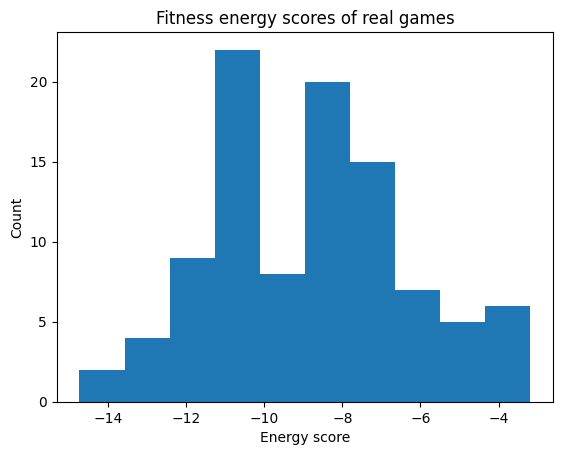

In [102]:
plt.hist(real_scores)
plt.title('Fitness energy scores of real games')
plt.xlabel('Energy score')
plt.ylabel('Count')

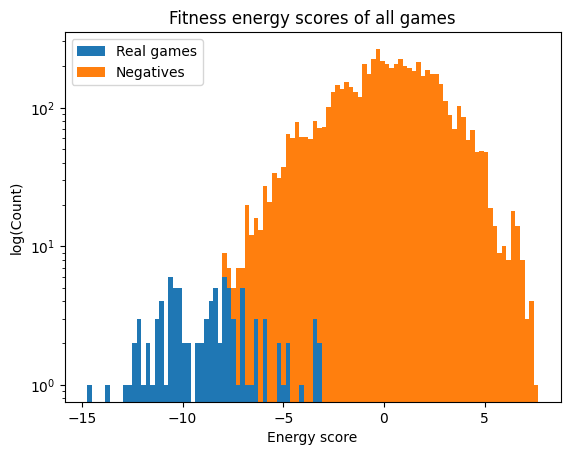

In [103]:
plt.hist([real_scores, negative_scores.flatten()], stacked=True, bins=100,
    label=['Real games', 'Negatives'])
plt.title('Fitness energy scores of all games')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')

In [104]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv.best_estimator_.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
weights.mean(), weights.std(), bias

(-3.50901e-05, 0.028054424, array(0.00042098, dtype=float32))

Text(0, 0.5, 'Count')

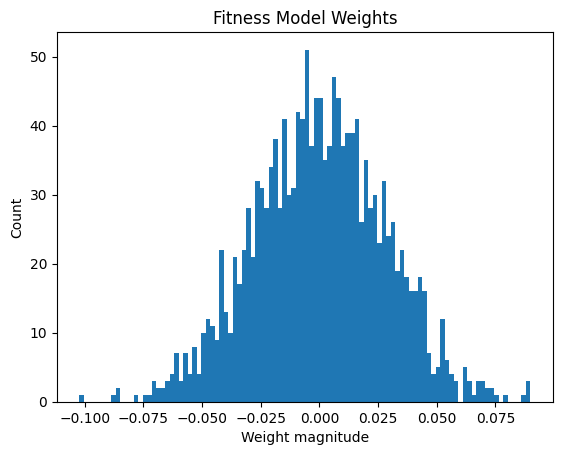

In [105]:
plt.hist(weights, bins=100)
plt.title('Fitness Model Weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')